In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
import torch.utils.data
import torchvision.transforms as transforms
import copy
from IPython.display import clear_output
from PIL import Image

In [2]:
import sys
sys.path.append("../")
from dataset.dataset import *
from util.util import *
from model.model import *

---

<font size="5">Overviews</font>
1. Introduction
1. CelebA dataset
1. Preparation of VAE
1. Training of VAE
1. Results

---

# Introduction
As I mentioned in README, LCGAN is divided into 3 procedures; 
VAE, Dimension Reduction, and Conditional GAN as you can see in the figure below.
This notebook focuses on the training of VAE colored blue in the diagram.

image of diagram

---

# CelebA dataset
---
In these experiments, I employed CelebA data. 
It's a face dataset which has plenty of annotations.
So we're able to set various classes among them.
I haven't explained the way to download the dataset, 
but the dataset usage doesn't need to be prioritized.

---
First of all, navigate "root" to directory of the dataset and "label root" to directory of the label folder.
I will explain how the make the label folder sometime.


In [3]:
root = "./../../research/sound_dataset/celebA/img_align_celeba_png/"
label_root = "../../research/sound_dataset/celebA/label_folder/"

---
As I said, CelebA dataset has plenty of annotations, so we need to define which annotation we're gonne use.
Obviously there are 3 ways to use it.

- ***existed***: Get the images which belong to the annotations.
- ***delete***: Delete the images which belong to the annotations.
- ***class***: These annotations are used to compose the classes, \# of classes will be $2^{\#\_classes}$

In this experiment, I used some annotations owing to simplicity and 
set the classes by the use of annotations; "male", "smiling", "young".

---

In [4]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32, 40] 

In [5]:
label_discription = [
    "male, smiling, young",
    "male, smiling, old",
    "male, not_smiling, young",
    "male, not_smiling, old",
    "female, smiling, young",
    "female, smiling, old",
    "female, not_smiling, young",
    "female, not_smiling, old"
]

classes = tuple(range(2**len(dataset_label["class"])))
classes

(0, 1, 2, 3, 4, 5, 6, 7)

---
Every image is center-cropped to (128x128).

---

In [6]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((128, 128)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((128, 128)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

---
So these are the samples of this dataset.

---

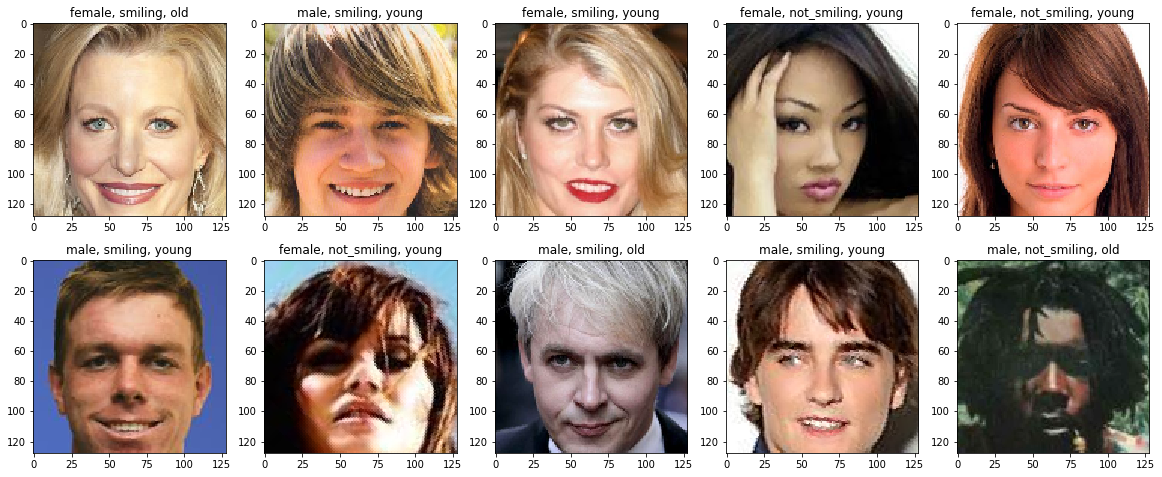

In [7]:
fig = plt.figure(figsize=(20, 8))
dataset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="train", train_num=3000, val_num=500, test_num=500)
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    index = np.random.randint(0,len(dataset))
    data = dataset[index]
    img = data[0]
    image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
    ax.imshow(image)
    ax.set_title(label_discription[data[1]])

# $\beta$ - VAE
This is the main part of the notebook.
I'm gonna expplain The preparation and the training of $\beta$ - VAE.

## Preparation

---
I set some parameters and they indicate as follows:
- ***epoch_num***: \# of epoches
- ***z_dim***: the dimension of the latent code
- ***lr***: learning rate
---

In [8]:
epoch_num = 1001
z_dim = 128
beta = 0.1
lr = 0.0001
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

---
I employed an adam optimizer and a scheduler which lowers the learning rate exponentially.

---

In [9]:
net = VAE(z_dim=z_dim, nch_input=3, nch=64, device=device).to(device)
net.apply(weights_init)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
Get the training and validation dataset.

---

In [10]:
each_train_num = 5000
each_val_num = 500
each_test_num = 500
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
valset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="val", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=256, shuffle=False)
len(dataset), len(valset)

(33594, 4000)

## Training
Let's start to train the model from now on.
At first, let's take a look at the function which is carried out testing the VAE.

---

In [11]:
def do_test_VAE(net, testloader, device="cuda", mode="train"):
    
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    
    labels = np.array([])
    losses = []
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = data[1].to(device)
            output, z = net(images)
            labels = np.append(labels, label.to("cpu").detach().numpy())
            losses.append(net.loss(images, beta=beta).to("cpu").detach().numpy())
            if itr==0:
                latents = z.to("cpu").detach().numpy()
                inputs = images.to("cpu").detach().numpy()
                outputs = output.to("cpu").detach().numpy()
            else:
                latents = np.concatenate([latents, z.to("cpu").detach().numpy()], axis=0)
                inputs = np.concatenate([inputs, images.to("cpu").detach().numpy()], axis=0)
                outputs = np.concatenate([outputs, output.to("cpu").detach().numpy()], axis=0)
                
    return labels, inputs, outputs, np.mean(losses), latents

### train

---
I'm not gonna test the model every epoch.
I will do it at some intervals.
And to see the result halfway, the visualized image is fixed among epoches.

---

In [12]:
save_parameter = True
test_interval = 3
fixed_image = dataset[0][0].view(1, 3, 128, 128).to(device)

---
Let's get started!

---

79
test loss in 78 : 1159.2685546875
best loss is   : 1155.056884765625 in epoch66


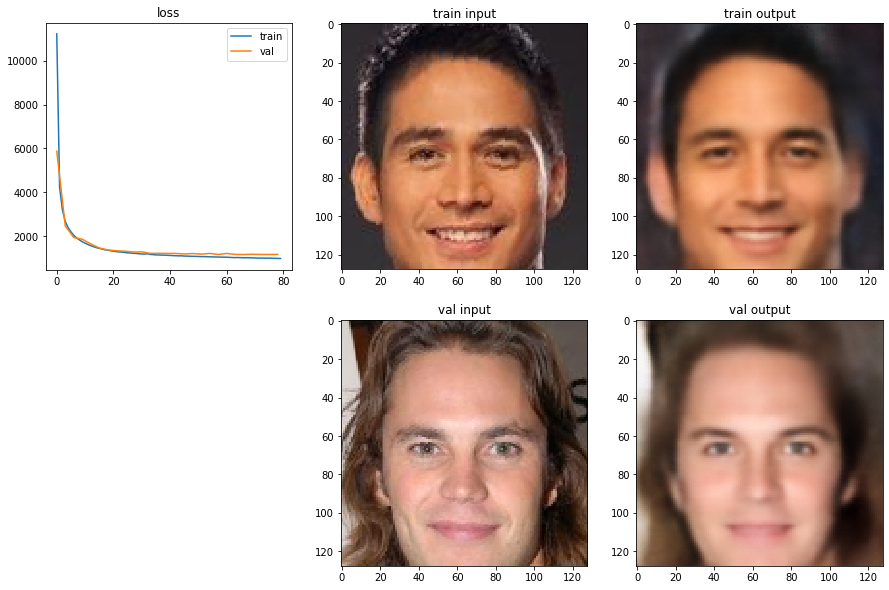

KeyboardInterrupt: 

In [13]:
losses_epoch = []
losses_epoch_test = []
best_epoch = 0
best_loss = np.inf
for epoch in range(epoch_num):
    losses = []
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        loss = net.loss(x, beta=beta)
        loss.backward()
        optimizer.step()
        
        loss = loss.to("cpu").detach().numpy()
        label = label.to("cpu").detach().numpy()
        losses.append(loss)
    losses_epoch.append(np.mean(np.array(losses)))
    scheduler.step()
    if epoch%test_interval==0:
        labels, inputs, outputs, loss_test, latents = do_test_VAE(net, valloader, device, "eval")
        losses_epoch_test.append(loss_test)
        if best_loss > loss_test:
            best_loss = loss_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test loss in {epoch//test_interval*test_interval} : {loss_test}")
    print(f"best loss is   : {best_loss} in epoch{best_epoch}")
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.state_dict(), 
                       f"./instant_model_parameter/VAE_celebA_ndim{z_dim}_beta{beta}_lr{lr}_epoch{epoch}.pth")
            
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(2,3,1)
    ax.plot(losses_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, losses_epoch_test, label="val")
    ax.legend()
    ax.set_title('loss')
    net.eval()
    fixed_output, _ = net(fixed_image)
    
    ax = fig.add_subplot(2,3,2)
    M = image_from_output(fixed_image)[0]
    ax.imshow(M)
    ax.set_title("train input")
    ax = fig.add_subplot(2,3,3)
    M = image_from_output(fixed_output)[0]
    ax.imshow(M)
    ax.set_title("train output")
    ax = fig.add_subplot(2,3,5)
    M = image_from_output(torch.tensor(inputs[0:1]))[0]
    ax.imshow(M)
    ax.set_title("val input")
    ax = fig.add_subplot(2,3,6)
    M = image_from_output(torch.tensor(outputs[0:1]))[0]
    ax.imshow(M)
    ax.set_title("val output")
    plt.show()

In [14]:
epoch = 66
load_model = True
if load_model:
    model_path = f"./instant_model_parameter/VAE_color_celebA_ndim{z_dim}_beta{beta}_lr{lr}_epoch{epoch}.pth"
    model_path = f"./instant_model_parameter/VAE_celebA_ndim{z_dim}_beta{beta}_lr{lr}_epoch{epoch}.pth"
    model_param = torch.load(model_path, map_location=device)
    net.load_state_dict(model_param)

---
Since the training is lengthy process, I've already trained it and saved the parameters.
Let's call it with the code below.

---

In [30]:
model_path = f"../data/parameters/VAE_color_celebA_ndim512_beta0.1_lr0.0001_epoch99.pth"
model_param = torch.load(model_path, map_location=device)
net.load_state_dict(model_param)

## Results

---
Check the output in test dataset.

---

In [15]:
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=256, shuffle=False)
len(testset)

4000

In [16]:
labels, inputs, outputs, loss_test, latents = do_test_VAE(net, testloader, device, "eval")

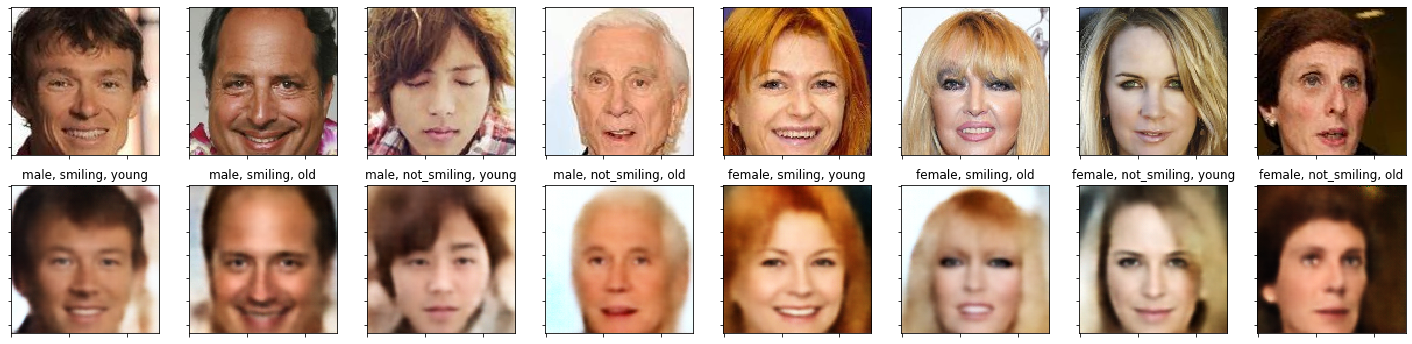

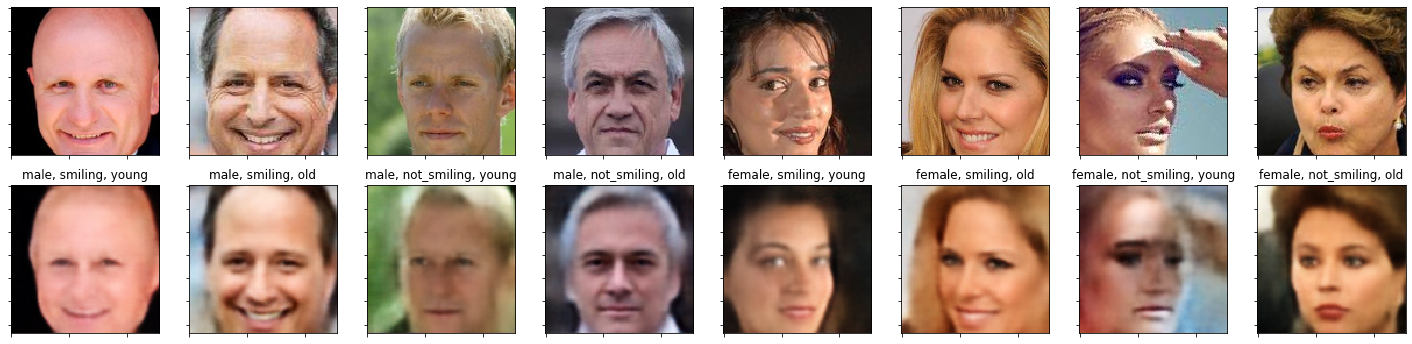

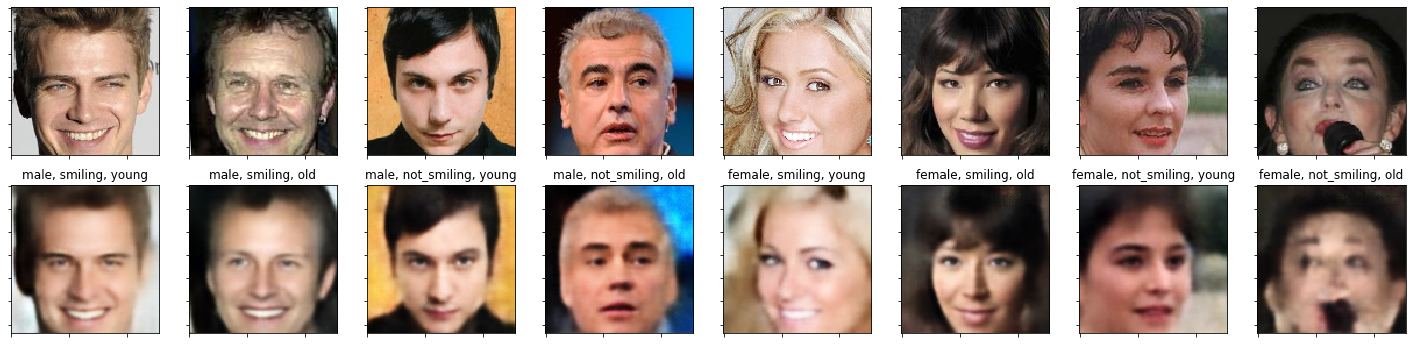

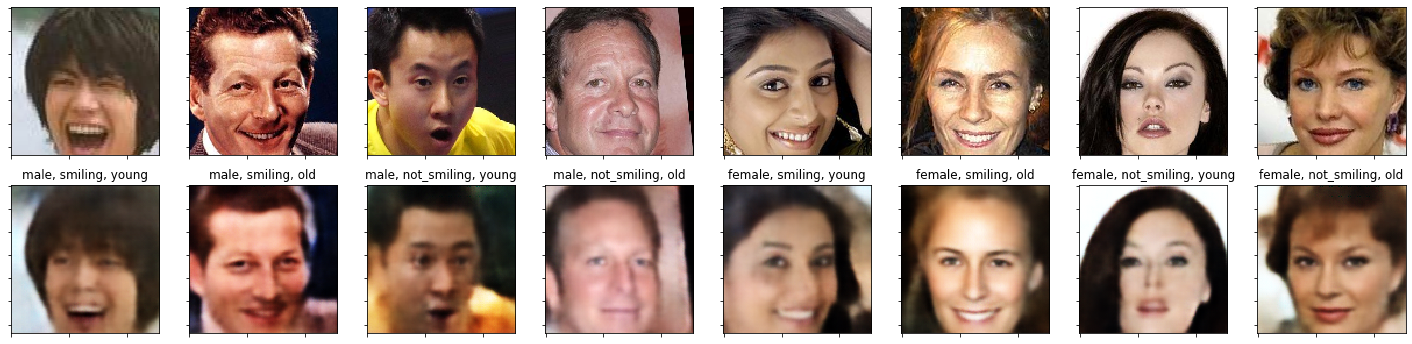

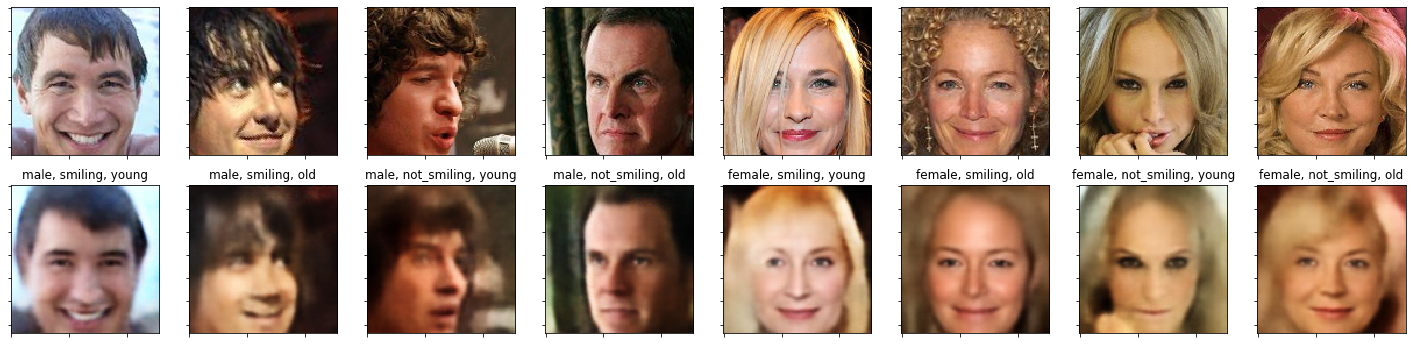

In [17]:
display_num = 5
ax = []
for i in range(display_num):
    fig = plt.figure(figsize=(25, 6), facecolor="w")
    for j in range(len(classes)):
        images_pool = labels == classes[j]
        ax = fig.add_subplot(2, len(classes), j+1)
        M = image_from_output(torch.tensor(inputs[images_pool][i:i+1]))[0]
        ax.imshow(M)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    for j in range(len(classes)):
        images_pool = labels == classes[j]
        ax = fig.add_subplot(2, len(classes), len(classes)+j+1)
        M = image_from_output(torch.tensor(outputs[images_pool][i:i+1]))[0]
        ax.imshow(M)
        ax.set_title(label_discription[j])
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.show()

---
As a results, we can distinguish the class by checking only the reconstructed image.
It means the compressed data, or the latent code certainly catches the information of the classes.
However the annotation "young" is relatively difficult. 
I think it's due to labeler's subjectivity and vanishing some features such as wrinkles.
In next notebook, I'm gonna observe the latent code and conduct dimension reduction which is applicable to further model.

---